# Nat Scott

## Research question/interests

**Is there a correlation between political alignment & living in neighbourhoods with large quantities of LGBT people?** The obvious answer to this question is "yes, they are going to mostly be democrats" but anyone who's ever been around queer people will know that this question is quite a bit more nuanced than that, and this nuance is what we hope to capture in investigating this question.

- The gaybourhoods data set does not include data on residents political alignments, however, there is a wealth of electoral data available freely online that we intend on incorporating into this project. The primary difficulty then will be developing a geographic "compatibility layer" between the data sets so that the data can be understood in the same context. To build this, we intend on working with the OpenStreetMap API to create an additional column representing observations position space in a more neutral way, such as their coordinates.
- Alternatively, we've also considered working with an additional data set that links US zip codes to their longitude and lattitude positions. As such, incorporating this data would be as easy as merging the two tables.


**Is there a correlation between geographical stratums & being LGBT?** This question is more abstract, and will serve as a preliminary exploration of the data in hopes of establishing two key details along the way that will shape the rest of the project: how do we quantify queerness, and how do we best represent it visually?

- Once again, representing this data visually will require determining the coordinates associated with each observation.
- The gaybourhoods data set defines a "gaybourhood index" which effectively measures how friendly a given neighbourhood is to queer people. Since this index is entirely subjective, we will need to closely evaluate it's usefulness for our project and investigate different ways to quantify "queer-friendliness"
- In addition to the last point, since, of course, no matter what choice of observations we make, the measurement will still be subjective, answering this research question will come more so in the form of comparing and contrasting different measurements to see what they tell us.
- Obviously, visualizing this among many aspects of the other research questions would involve projecting the data onto a map of the United States, so visualizing this research question would motivate many of the visualizations for other components of this project

In [50]:
import pandas as pd
import seaborn as sns

## Data Wrangling

In [76]:
## counties - Relating US counties to their long/lat position on the Earth
counties = pd.read_csv("../data/raw/us-county-boundaries.csv", sep=";")

counties = counties.rename({
    "NAME": "name",
    "INTPTLAT": "lat",
    "INTPTLON": "long",
}, axis="columns")

# Combine the county name with the state code
def combine_name_state(row):
    row["name"] = f"{row['name']} {row['STUSAB']}"
    return row

counties = counties.apply(combine_name_state, axis="columns")

# We don't need this column anymore
counties = counties.drop(["STUSAB"], axis="columns")

counties.to_csv("../data/processed/us-county-boundaries.csv")
counties.head()

name        lat       long
0   Hancock OH  41.000471 -83.666033
1  Stafford VA  38.413261 -77.451334
2   Webster NE  40.180646 -98.498590
3    Dimmit TX  28.423587 -99.765871
4     Cedar IA  41.772360 -91.132610

In [107]:
## pol - Election results from the 2012 American presidential election
pol = pd.read_csv("../data/raw/countypres_2000-2020.csv")

# We only want 2012--the latest election before the gb data was collected

pol = pol[pol["year"] == 2012].reset_index()

# Get rid of undesireable columns
pol = pol.drop([
    "year", "state", "county_fips", "office",
    "candidate", "version", "mode", "index",
], axis="columns")

# Change the column names to make them a little more friendly
pol.rename({
    "county_name": "county",
    "state_po": "state",
    "candidatevotes": "votes",
    "totalvotes": "total"
}, axis="columns", inplace=True)

# Make cells lowercase
pol["county"] = pol["county"].apply(lambda x: x.capitalize())
pol["party"] = pol["party"].apply(lambda x: x.capitalize())

# Combine the county name with the state code
def combine_name_state(row):
    row["county"] = f"{row['county']} {row['state']}"
    return row

pol = pol.apply(combine_name_state, axis="columns")

# Add a percent column which will be useful when graphing
pol["percent"] = pol["votes"] / pol["total"]

# Attach long/lat data to each row
pol = pol.merge(counties, left_on="county", right_on="name")

# Now we can get rid of the state columns
pol = pol.drop(["state", "name", "county"], axis="columns")

pol.to_csv("../data/processed/election-2012.csv", index=False)
pol.head()

party  votes  total   percent        lat       long
0    Democrat   6363  23932  0.265878  32.532237 -86.646439
1  Republican  17379  23932  0.726183  32.532237 -86.646439
2       Other    190  23932  0.007939  32.532237 -86.646439
3    Democrat  18424  85338  0.215894  30.659218 -87.746067
4  Republican  66016  85338  0.773583  30.659218 -87.746067

In [87]:
## gb - the gaybourhoods dataset
gb = pd.read_csv("../data/raw/gaybourhoods.csv")
cords = pd.read_csv("../data/raw/zip_lat_long.csv")

# Let's add long/lat columns to gb
gb = gb.merge(cords, left_on="GEOID10", right_on="ZIP")

# Get rid of unneeded columns
gb = gb.drop([
    "Mjoint_MF", "Mjoint_SS", "Mjoint_FF", "Mjoint_MM",
    "Cns_TotHH", "Cns_UPSS", "Cns_UPFF", "Cns_UPMM",
    "ParadeFlag", "FF_Tax", "FF_Cns", "MM_Tax", "MM_Cns",
    "SS_Index_Weight", "Parade_Weight", "Bars_Weight",
    "GEOID10", "ZIP",
], axis="columns")

# There's a lot of info baked into some of these columns. Especially the composite indexes.
# We'll leave their names as is for easy reference even if they're a little ugly.
gb = gb.rename({
    "LAT": "lat",
    "LNG": "long",
}, axis="columns")

gb.to_csv("../data/processed/gaybourhoods-nat.csv")
gb.head()

Tax_Mjoint  TaxRate_SS  TaxRate_FF  TaxRate_MM  Cns_RateSS  Cns_RateFF  \
0        2120  203.301887   28.773585  174.528302   77.125329    6.931719   
1        5080  205.511811   33.464567  172.047244   88.478367   15.617404   
2        5790  107.772021   16.753022   91.018998   46.771050    5.745582   
3        3510   80.056980   21.082621   58.974359   31.619291    9.315448   
4        2660   91.353383   12.781955   78.571429   21.763042    3.142678   

   Cns_RateMM  CountBars  FF_Index   MM_Index   SS_Index   TOTINDEX  \
0   70.193610         15  6.724415  48.288254  55.012669  67.077054   
1   72.860963         17  9.834048  48.578469  58.412517  61.866815   
2   41.025469          5  4.370779  26.360413  30.731192  37.908747   
3   22.303843         10  6.055939  15.939869  21.995808  37.530067   
4   18.620365          9  3.004058  18.280165  21.284224  35.843573   

         lat        long  
0  34.093828 -118.381697  
1  37.758057 -122.435410  
2  40.742039  -74.000620  
3  40.734012  -74.006746  
4  37.773134 -122.411167

## Exploratory Data Analysis

In the previous section we got a pretty good idea of what the data looks like and managed to condense it to fewer key variables that will be useful when answering the research questions established above. Now, we will compare these variables, attempt to create some plots, and see if we can't uncover any interesting relationships that aren't evident by looking at the numbers alone.

Let's start with a scatterplot of the `gb` data set. I have no idea what this is going to look like. Let's see:

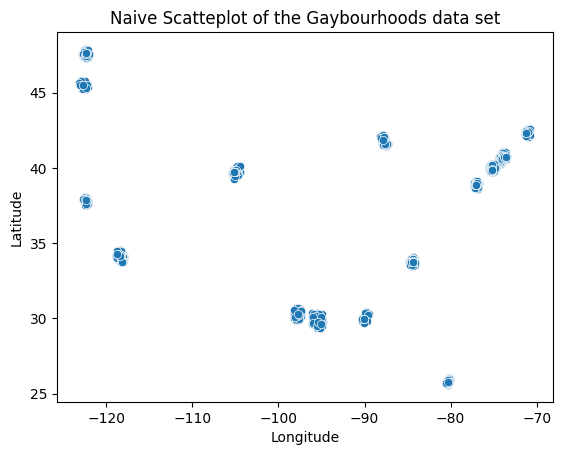

In [109]:
plot_naive_scatter1 = sns.scatterplot(data=gb, x="long", y="lat")
_ = plot_naive_scatter1.set(
    xlabel="Longitude",
    ylabel="Latitude",
    title="Naive Scatteplot of the Gaybourhoods data set"
)

Here the data does appear to trace the outline of the United States, probably because most of the cities the data set covers are along the coast. We can do something similar with the election data we cleaned earlier:

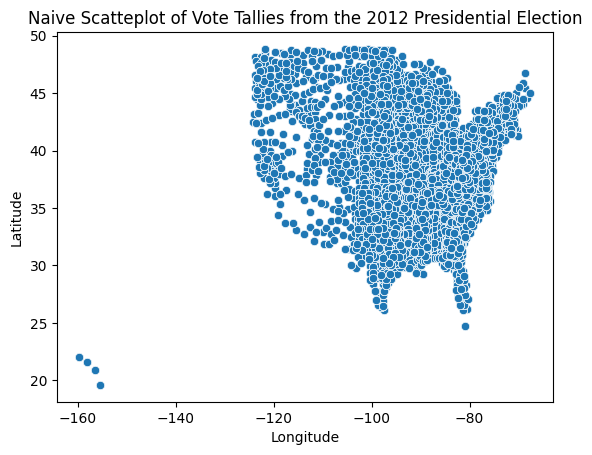

In [108]:
plot_naive_scatter2 = sns.scatterplot(data=pol, x="long", y="lat")
_ = plot_naive_scatter2.set(
    xlabel="Longitude",
    ylabel="Latitude",
    title="Naive Scatteplot of Vote Tallies from the 2012 Presidential Election"
)

This plot looks a little weird, which probably has to do in part with the fact that we are very thoughtlessly trying to project a portion of a geoid onto a cartesian plane using a measurement that is not cartesean coordinates

Another issue with these plots is the fact that the data is very messy. It's not all that meaningful for more reasons than just the fact that it's messy, but being messy doesn't help all that much

One thing that stands out is the outliers in the bottom left of the plot, which is clearly Hawaii. Hawaii is not covered by the Gaybourhoods data set at all so we can remove these rows like so:

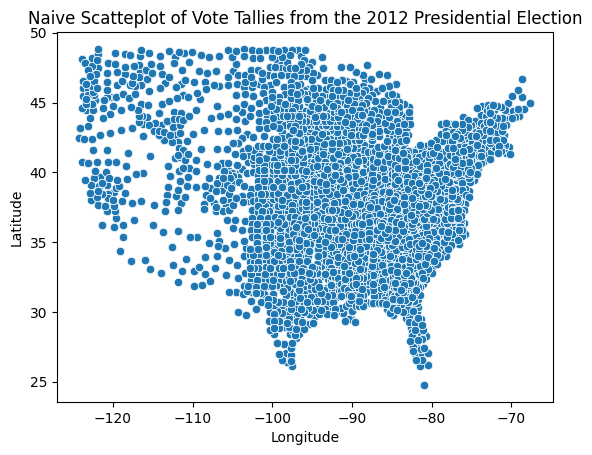

In [111]:
pol = pol[pol["long"] > -140]

plot_naive_scatter3 = sns.scatterplot(data=pol, x="long", y="lat")
_ = plot_naive_scatter3.set(
    xlabel="Longitude",
    ylabel="Latitude",
    title="Naive Scatteplot of Vote Tallies from the 2012 Presidential Election"
)

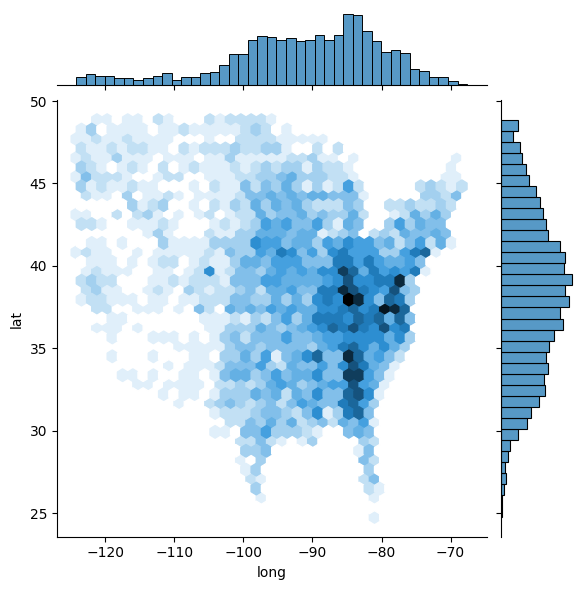

In [116]:
# A prettier way to represent the number of observations in a given region
# would be to use a hexbin plot:
plot_naive_hexbin = sns.jointplot(data=pol, x="long", y="lat", kind="hex")

There are quite a few counties concentrated around the east coast, above Florida and below New Hampshire. On the other hand, there are far fewer individual counties along the west coast. This is all pretty self-evident.

Number of data points in the region of New York: 131


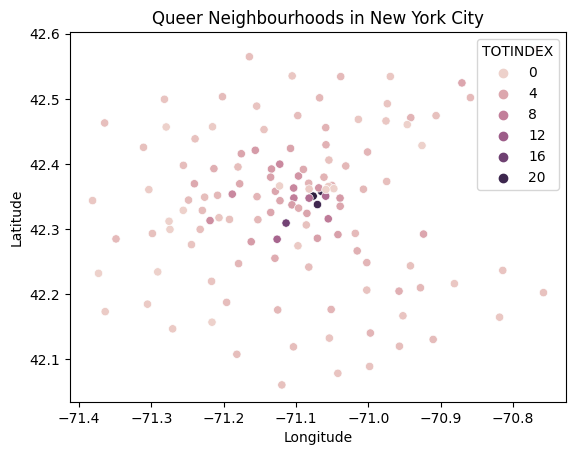

In [125]:
# New York is one of the cities covered by the Gaybourhoods data set.
# Let's take a closer look at it:

gb_ny = gb[gb["long"] > -73]
print(f"Number of data points in the region of New York: {gb_ny.shape[0]}")
plot_ny_scatter1 = sns.scatterplot(data=gb_ny, x="long", y="lat", hue="TOTINDEX")
_ = plot_ny_scatter1.set(
    xlabel="Longitude",
    ylabel="Latitude",
    title="Queer Neighbourhoods in New York City"
)

In the above plot, we colour points darker the higher their "gaybourhood index" is. This index is a weighted composite of a few factors. The TOTINDEX boldy weighs the queerness of same-sex married couples more than unmarried same-sex households. While it's subjective, in my opinion, this marginalizes the experiences of queer people who have no desire to marry.

If we wanted to look at unmarried same sex households alone, we could use the "Cns_RateSS" column:

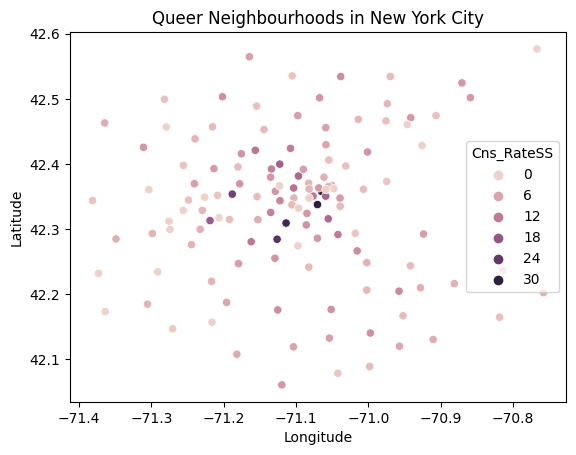

In [126]:
plot_ny_scatter2 = sns.scatterplot(data=gb_ny, x="long", y="lat", hue="Cns_RateSS")
_ = plot_ny_scatter2.set(
    xlabel="Longitude",
    ylabel="Latitude",
    title="Queer Neighbourhoods in New York City"
)

As predicted, the diversity of the data becomes more apparent when we don't hide it. While the difference isn't extremely substantial, it will be worthwhile to continue to analyze multiple factors when exploring this data. This is especially the case when we consider the fact that the data set is already very limited in how it fails to account for gender diversity.

Just for fun, let's do something similar for the political dataset:

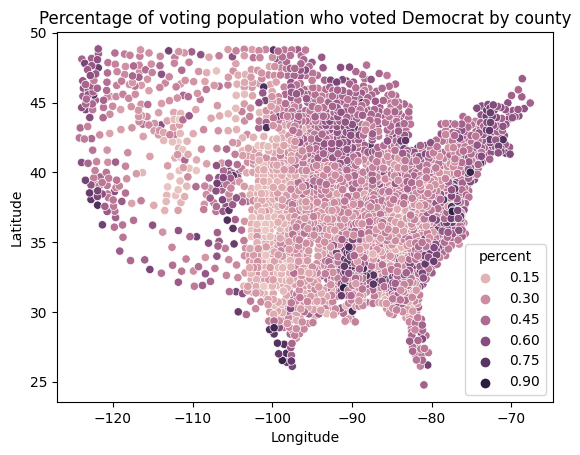

In [129]:
plot_democrat_scatter = sns.scatterplot(
    data=pol[pol["party"] == "Democrat"],
    x="long",
    y="lat",
    hue="percent"
)
_ = plot_democrat_scatter.set(
    xlabel="Longitude",
    ylabel="Latitude",
    title="Percentage of voting population who voted Democrat by county"
)

A better way to represent this data would be to use a heatmap, but even this scatterplot reveals something we probably already knew: Democrats tend to be concentrated around the urban parts of the United States

## Renewed Analysis Plan

The research questions posed earlier in this analysis still feel sufficiently specific, having clear, measurable goals and room for additional analysis. Here are two very rough step-by-step plans to answer the two research questions I seek to answer in this analysis:

**Is there a correlation between political alignment & living in neighbourhoods with large quantities of LGBT people?**
1. Unify the political data with the gaybourhoods data set
  1. Establish the best way to measure the distance from a given `gb` and a county (Euclidean distance? Some other measurement?)
  2. Find the county that is closest to each observation by minimizing the function established in step (a)
  c. Merge the two tables. Each `gb` observation should then include a political breakdown of the nearest county during the 2012 presidential election
2. Use this information to plot queerness by different metrics against political alignment and measure the correlation

**Is there a correlation between geographical stratums & being LGBT?**
1. Explore different metrics of queerness and analize more qualitatively how different metrics reveal different information in different places by graphing them
2. Graph and measure the clusteredness of neighbourhoods surpassing different threshholds of queerness
3. If the previous steps show that this is a relevant line of inquiry: measure and graph the rate of change in queerness radially outward from clusters of queer neighbourhoods
